In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  1 18:31:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install tensorflow-gpu
!pip install Keras

     |████████████████████████████████| 394.3MB 41kB/s 


In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime, os

In [ ]:
import datetime
import sys
import os
import numpy as np
import pandas as pd
import sklearn 
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import Sequential
import tensorflow.keras.backend as K
from keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, merge, 
                         Concatenate, Flatten, RepeatVector, Lambda, Bidirectional, SimpleRNN)
from keras.models import Model
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from tensorflow.keras.callbacks import (Callback, TensorBoard, EarlyStopping,
                             ModelCheckpoint, CSVLogger, ProgbarLogger)
import sys
import csv
from collections import Iterable, OrderedDict
import datetime
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading AGN alert's light curves


In [ ]:
#reading list of lcs already saved 
lcs= np.load('/content/drive/Shareddrives/Stargaze/datasets/ps_DR5_data/balanced_inndet_inprop_DR5_SDSSDR14_QSO_noblazar_gband_lcs_list.npy',allow_pickle=True)

In [ ]:
print(len(lcs))

24755


In [ ]:
#printing a section of a lc as example
print(lcs[100][0:5])

[[5.83234411e+04 2.01629238e+01 1.46320924e-01]
 [5.83355002e+04 1.98275146e+01 1.19798183e-01]
 [5.83384397e+04 2.00872803e+01 1.40354425e-01]
 [5.83424204e+04 2.00872231e+01 1.40349880e-01]
 [5.83424337e+04 2.02001591e+01 1.49213240e-01]]


In [ ]:
#shuffling the data to avoid systematics 
np.random.seed(42)
np.random.shuffle(lcs)
lcs[100][0:5]

array([[5.82044018e+04, 2.02587128e+01, 1.21813253e-01],
       [5.82044509e+04, 2.06296825e+01, 1.51942968e-01],
       [5.82044640e+04, 2.06181564e+01, 1.51120782e-01],
       [5.82044649e+04, 2.04469032e+01, 1.37976155e-01],
       [5.82044974e+04, 2.03973961e+01, 1.33613288e-01]])

In [ ]:
#lcs = lcs[:10000]
#print(len(lcs))

In [ ]:
#padding the lcs
lcs_raw = pad_sequences(lcs, value=np.nan, dtype='float', padding='post')

In [ ]:
print(lcs_raw[100][0:5])

[[5.82044018e+04 2.02587128e+01 1.21813253e-01]
 [5.82044509e+04 2.06296825e+01 1.51942968e-01]
 [5.82044640e+04 2.06181564e+01 1.51120782e-01]
 [5.82044649e+04 2.04469032e+01 1.37976155e-01]
 [5.82044974e+04 2.03973961e+01 1.33613288e-01]]


**Preprocess for the input data:** 

MJD -> $\Delta$MJD/365.0

mag -> [mag - mean(mag)]/std(mag)

In [ ]:
#functions taken from https://github.com/yutarotachibana/CatalinaQSO_AutoEncoder

def times_to_lags(T):
    """(N x n_step) matrix of times -> (N x n_step) matrix of lags.
    First time is assumed to be zero.
    """
    assert T.ndim == 2, "T must be an (N x n_step) matrix"
    return np.c_[np.diff(T, axis=1)/365., np.zeros(T.shape[0])]


def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    return X, means, scales, errors, wrong_units

In [ ]:
lcs_scaled, means, scales, errors, wrong_units = preprocess(lcs_raw)

In [ ]:
print(lcs_scaled[100][0:5])

[[ 1.34513151e-04 -1.36363299e+00]
 [ 3.59271233e-05  8.17188280e-01]
 [ 2.63178083e-06  7.49429743e-01]
 [ 8.89142466e-05 -2.57317226e-01]
 [ 2.53698630e-06 -5.48354841e-01]]


In [ ]:
print(means[100])

[20.49067428]


Input for Autoencoder

In [ ]:
main_input = Input(shape=(lcs_scaled.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(lcs_scaled.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

w = 1/err, loss = [w(y-y$_{\rm pred}$)]$^2$ (reduced $\chi$ squre)

In [ ]:
sample_weight = 1. / errors
sample_weight[np.isnan(sample_weight)] = 0.0
lcs_scaled[np.isnan(lcs_scaled)] = 0.

In [ ]:
lcs_scaled[:, :, [1]]

array([[[ 2.11643395],
        [ 1.04999638],
        [ 1.60605501],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 1.3536838 ],
        [ 1.95959744],
        [ 2.08179087],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.31362354],
        [-0.38869804],
        [ 0.7747209 ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[-1.87646413],
        [-1.2402999 ],
        [-1.74677622],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.22562308],
        [ 1.00637528],
        [-1.32192109],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-1.0867338 ],
        [-0.41399918],
        [-0.88396798],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]])

# Autoencoder Model

Defining the autoencoder model. Based on the work of Tachibana et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020ApJ...903...54T/abstract), but using GRU instead of LSTM

---



In [ ]:
lr = 1e-3 #learning rate 
optimizer = Adam(lr=lr)
output_size=16
gru_size = 32
nepochs = 2000
batchsize = 512
dropout_val = 0.25

resume_training = False # if True use W&B to recover weights and resume training, if False train a new model

In [ ]:
def sampling(samp_args):
    z_mean, z_log_sigma = samp_args

    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

Using Tachibana+2020 aproach: 2 LSTM layers for encoding and decoding, and an encoding of length 16

In [ ]:

#encoder
encoder = Bidirectional(GRU(gru_size, name='encoder1', return_sequences=True))(main_input)
encoder = Dropout(dropout_val, name='drop_encoder1')(encoder) 
encoder = Bidirectional(GRU(gru_size, name='encoder2', return_sequences=False))(encoder)
encoder = Dropout(dropout_val, name='drop_encoder2')(encoder)
codings_mean = Dense(units=output_size, name='encoding_mean', activation='linear')(encoder)
codings_log_var = Dense(units=output_size, name='encoding_log_var', activation='linear')(encoder) 
codings = Lambda(sampling, output_shape=(output_size,))([codings_mean, codings_log_var])


#decoder
decoder = RepeatVector(lcs_scaled.shape[1], name='repeat')(codings)
decoder = merge.concatenate([aux_input, decoder])
decoder = GRU(gru_size, name='decoder1', return_sequences=True)(decoder)
decoder = Dropout(dropout_val, name='drop_decoder1')(decoder)
decoder = GRU(gru_size, name='decoder2', return_sequences=True)(decoder)
decoder = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decoder)

#VAE
model = Model(model_input, decoder)



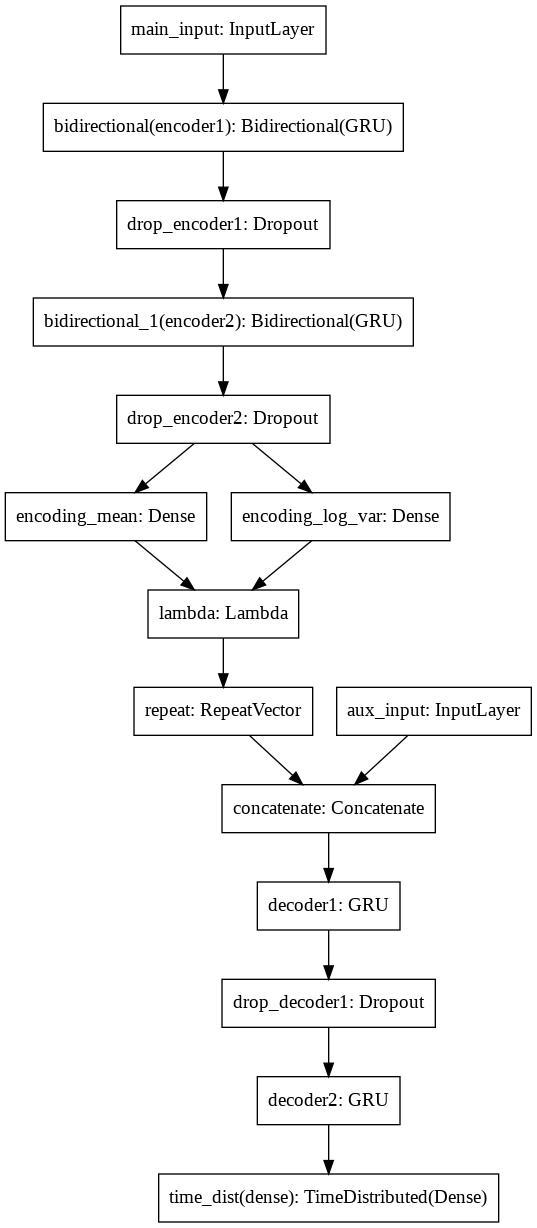

In [ ]:
plot_model(model, to_file='/content/drive/MyDrive/CSAGNs/plots_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/VAE_GRU2x32-encoding16_model.png')


In [ ]:

latent_loss = -0.5*K.sum(1+codings_log_var-K.exp(codings_log_var)-K.square(codings_mean),axis=-1)
model.add_loss(K.mean(latent_loss)/200.)
model.compile(optimizer=optimizer, loss='mse',  metrics=[tf.keras.metrics.MeanAbsoluteError()], weighted_metrics=[tf.keras.metrics.MeanAbsoluteError()], sample_weight_mode='temporal')#,run_eagerly=True)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 925, 2)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 925, 64)      6912        main_input[0][0]                 
__________________________________________________________________________________________________
drop_encoder1 (Dropout)         (None, 925, 64)      0           bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           18816       drop_encoder1[0][0]              
______________________________________________________________________________________________

In [ ]:
log_dir = '/content/drive/MyDrive/CSAGNs/models_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/'
weights_path = os.path.join(log_dir, 'weights_lr1e3_4paper.h5')
logs = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:


early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='auto', restore_best_weights=True)
check_points = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, save_freq='epoch', save_weights_only=False, save_best_only=True, monitor='val_loss', verbose=1)

#aux input contains the delta times, Y (lcs_scaled[:, :, [1]]) is the arrey with the normalized magnitudes, sample_weights is 1/err
history = model.fit({'main_input': lcs_scaled, 'aux_input': np.delete(lcs_scaled, 1, axis=2)},
                    lcs_scaled[:, :, [1]], 
                    epochs=nepochs, 
                    batch_size=batchsize,
                    sample_weight=sample_weight,
                    callbacks = [
                                check_points,
                                early_stopping
                                 ],
                
                    validation_split=0.2,
                    )

Epoch 1/2000
39/39 [==============================] - 46s 554ms/step - loss: 0.6881 - mean_absolute_error: 0.4530 - weighted_mean_absolute_error: 0.8310 - val_loss: 0.6329 - val_mean_absolute_error: 0.3398 - val_weighted_mean_absolute_error: 0.7951

Epoch 00001: val_loss improved from inf to 0.63289, saving model to /content/drive/MyDrive/CSAGNs/models_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/weights_lr1e3_4paper.h5
Epoch 2/2000
39/39 [==============================] - 18s 472ms/step - loss: 0.6329 - mean_absolute_error: 0.3482 - weighted_mean_absolute_error: 0.7964 - val_loss: 0.6319 - val_mean_absolute_error: 0.3403 - val_weighted_mean_absolute_error: 0.7943

Epoch 00002: val_loss improved from 0.63289 to 0.63186, saving model to /content/drive/MyDrive/CSAGNs/models_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/weights_lr1e3_4paper.h5
Epoch 3/2000
39/39 [==============================] - 18s 471ms/step - loss: 0.6373 - mean_absolute_error: 0

In [ ]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_mae  = history.history['mean_absolute_error']
val_mae    = history.history['val_mean_absolute_error']
train_wmae  = history.history['weighted_mean_absolute_error']
val_wmae    = history.history['val_weighted_mean_absolute_error']
xc         = range(len(train_loss))

df_history = pd.DataFrame({'epoch': xc, 'train_loss': train_loss, 'val_loss': val_loss, 
                           'train_mae': train_mae, 'val_mae': val_mae,
                           'train_wmae': train_wmae, 'val_wmae': val_wmae})

history_path = os.path.join(log_dir, 'train_history_4paper_lr1e3.csv')


df_history.to_csv(history_path)

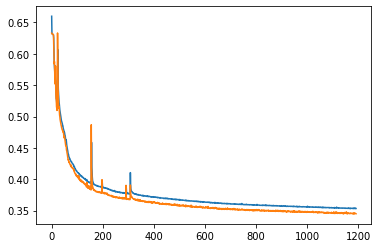

In [ ]:
plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)

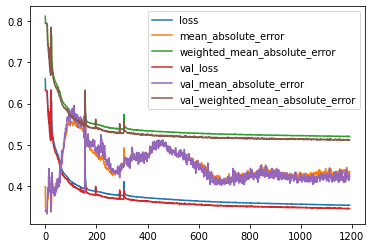

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.savefig('/content/drive/MyDrive/CSAGNs/plots_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/GRU2x32-encoding16_loss.png')

Dividing the model into the encoding and the decoding parts, and getting encoded features and decoded light curves

In [ ]:
encode_model = Model(model.input, model.get_layer('lambda').output)
decode_model = Model(model.input, model.output)
encoding = encode_model.predict({'main_input': lcs_scaled, 'aux_input': np.delete(lcs_scaled, 1, axis=2)})
decoding = decode_model.predict({'main_input': lcs_scaled, 'aux_input': np.delete(lcs_scaled, 1, axis=2)})

In [ ]:
encoding_train = encoding[0:int(0.8*len(lcs))]
encoding_val = encoding[int(0.8*len(lcs)):len(lcs)]
decoding_train = decoding[0:int(0.8*len(lcs))]
decoding_val = decoding[int(0.8*len(lcs)):len(lcs)]
X_raw_train = lcs_raw[0:int(0.8*len(lcs))]
X_raw_val = lcs_raw[int(0.8*len(lcs)):len(lcs)]
X_train = lcs_scaled[0:int(0.8*len(lcs))]
X_val = lcs_scaled[int(0.8*len(lcs)):len(lcs)]
scales_train = scales[0:int(0.8*len(lcs))]
scales_val = scales[int(0.8*len(lcs)):len(lcs)]
means_train = means[0:int(0.8*len(lcs))]
means_val = means[int(0.8*len(lcs)):len(lcs)]

Plotting modeled light curves and features for the training set

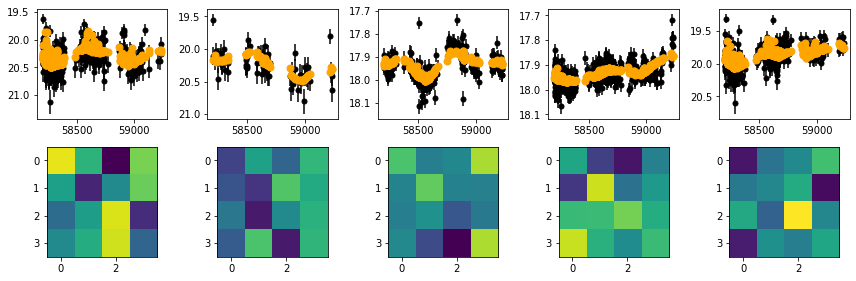

Upper panels: Input light curves (black points) and decoded light curves (orange points) 

Lower panels: Encoded 16 features


In [ ]:
i = 15000 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    #print(X_raw_train[num][:,0])
    #print(365.0*np.cumsum(X_train[num][:, 0][X_train[num][:, 0]>0])+X_raw_train[num][0,0])
    plt.errorbar(X_raw_train[num][:,0], X_raw_train[num][:,1], yerr=X_raw_train[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_train[num][:, 0][X_train[num][:, 0]>0])+X_raw_train[num][0,0], 
             decoding_train[num][X_train[num][:, 0]>0]*scales_train[num]+means_train[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding_train[num].reshape(4,4), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CSAGNs/plots_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/ZTF_alerts_modeled_lcs_training_set.png')
plt.show()

print("""Upper panels: Input light curves (black points) and decoded light curves (orange points) \n
Lower panels: Encoded 16 features""")

Plotting modeled light curves and features for the validation set

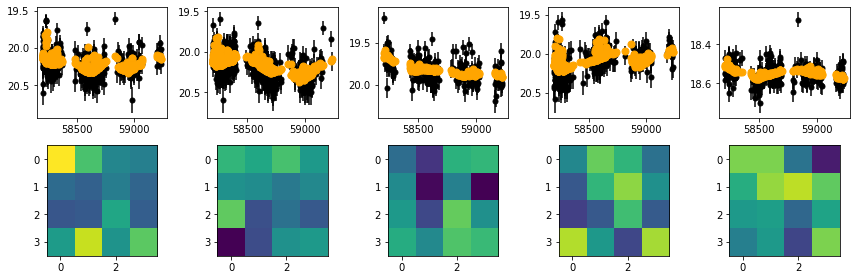

In [ ]:
i = 1650 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_raw_val[num][:,0], X_raw_val[num][:,1], yerr=X_raw_val[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(365.0*np.cumsum(X_val[num][:, 0][X_val[num][:, 0]>0])+X_raw_val[num][0,0], 
             decoding_val[num][X_val[num][:, 0]>0]*scales_val[num]+means_val[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding_val[num].reshape(4,4), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CSAGNs/plots_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/ZTF_alerts_modeled_lcs_validation_set.png')
plt.show()

Computing and plotting reduced chi-square distribution of the training and validation sets

In [ ]:
def calc_redchisq(x, x_pred, weight):
    mask =  (~np.isnan(weight))
    out = np.sum(((x[mask]-x_pred[mask])*weight[mask])**2)/len(weight[mask])
    return out

RedChiSq = []
print('Caluculating reduced chi-square for each source')
for m in range(0, len(lcs_raw)):
    if m%100 == 0:
        print('.', end='')
    RedChiSq.append(calc_redchisq(lcs_scaled[m][:,1]*scales[m]+means[m], np.squeeze(decoding[m]*scales[m]+means[m]), 1/lcs_raw[m][:,2]))

Caluculating reduced chi-square for each source
........................................................................................................................................................................................................................................................

In [ ]:
RedChiSq_train = RedChiSq[0:int(0.8*len(lcs))]
RedChiSq_val = RedChiSq[int(0.8*len(lcs)):len(lcs)]

In [ ]:
print("training chi2 median, mean: ",np.median(np.array(RedChiSq_train)),np.mean(np.array(RedChiSq_train)))
print("validation chi2 median, mean: ",np.median(np.array(RedChiSq_val)),np.mean(np.array(RedChiSq_val)))

training chi2 median, mean:  1.418706066922774 1.6492452127514312
validation chi2 median, mean:  1.4220208836994037 1.7044054215950595


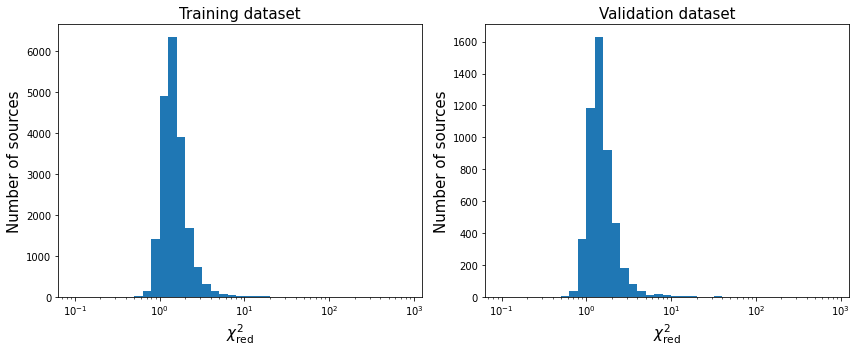

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.array(RedChiSq_train)[~np.isnan(RedChiSq_train)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Training dataset', fontsize=15)
plt.tight_layout()

plt.subplot(1,2,2)
plt.hist(np.array(RedChiSq_val)[~np.isnan(RedChiSq_val)], 
         bins=10**np.arange(-1, 3, 0.1))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Validation dataset', fontsize=15)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CSAGNs/plots_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/ZTF_alerts_chisquare_distribution.png')
plt.show()


# Evaluating the encoded features



Visualizing the distribution of the encoded features by t-SNE

In [ ]:
X_reduced_train =TSNE(n_components=2, perplexity=100, random_state=32, n_iter=1000).fit_transform(encoding_train)

In [ ]:
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns
from matplotlib import gridspec as grs
from scipy import stats

def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 200, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
rx, ry, rz = kde_contour_dat(X_reduced_train[:, 0], X_reduced_train[:, 1], grid_bins=100, BW=[2,2], extent=[-50, 50, -50, 50])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


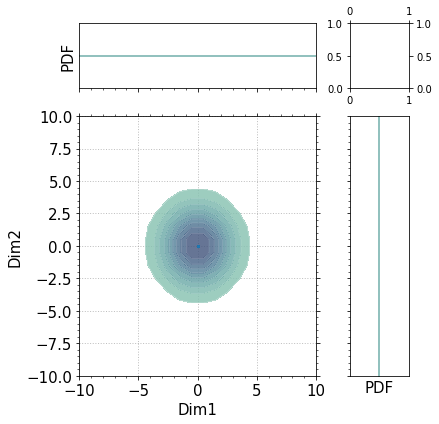

In [ ]:
X, Y = X_reduced_train[:, 0], X_reduced_train[:, 1]

xlims = [-10, 10]
ylims = [-10, 10]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
plt.figure(figsize=(6, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
ax[0].contourf(rx, ry, rz, levels = levels,
             origin = origin,
             cmap = cmap, alpha = 0.8)
ax[0].contour(rx, ry, rz, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax[0].scatter(X_reduced_train[:, 0], X_reduced_train[:, 1],s=1)
ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Dim1', fontsize=15)
ax[0].set_ylabel('Dim2', fontsize=15)

n = (np.linspace(ylims[0]-5, ylims[1]+5,200))
kde_X = stats.gaussian_kde(X)
kde_Y = stats.gaussian_kde(Y)
ax[1].fill_betweenx(n, kde_Y(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(kde_Y(n)))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.linspace(xlims[0]-5, xlims[1]+5,200))
ax[2].fill(n, kde_X(n), alpha=0.75, color=cmap(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(kde_X(n)))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CSAGNs/plots_DR5/VAE_psDR5_SDSS_QSO_balanced_detprop_GRU2x32-encoding16_gband/ZTF_alerts_tSNE_encoded_features.png')
plt.show()